In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from pathlib import Path

import numpy as np
from matplotlib import pyplot as plt

import lsstypes as types
sys.path.insert(0, '../')
import tools

In [3]:
plot_dir = Path('_plots')
plot_dir.mkdir(exist_ok=True)
ext = 'png'

[(0.4, 1.1)]


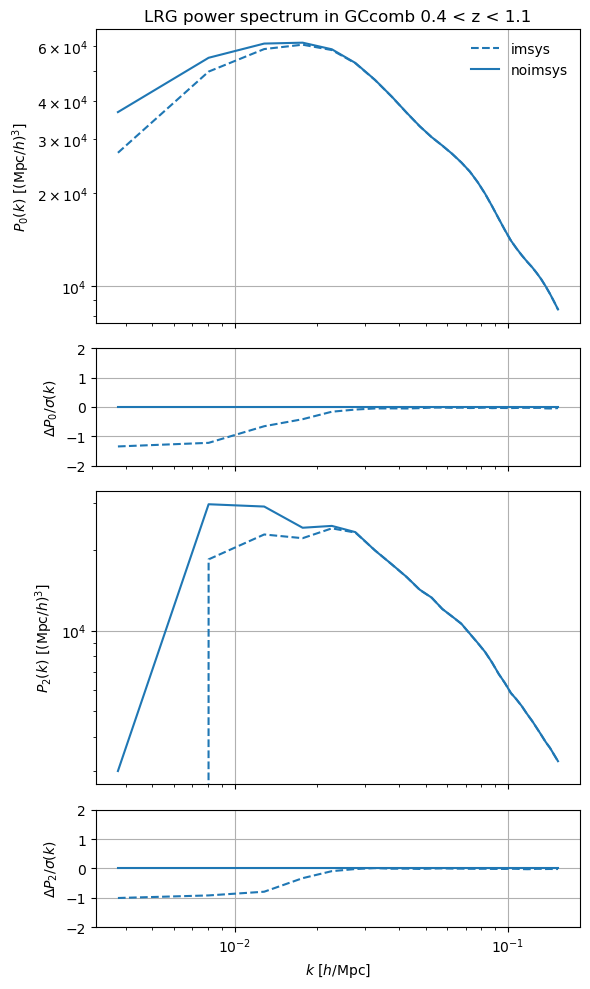

[(0.8, 1.6)]


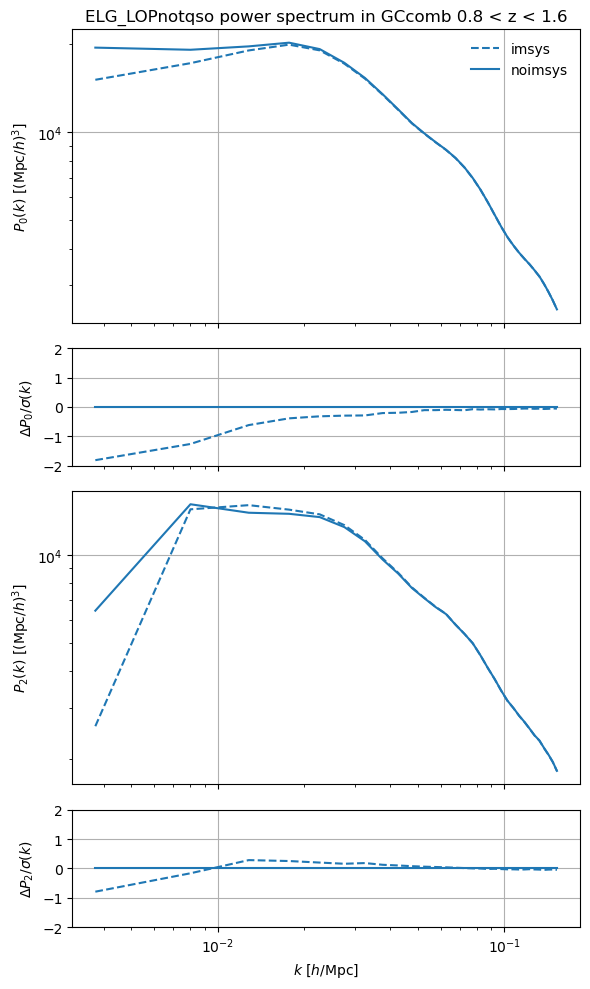

[(0.8, 3.5)]


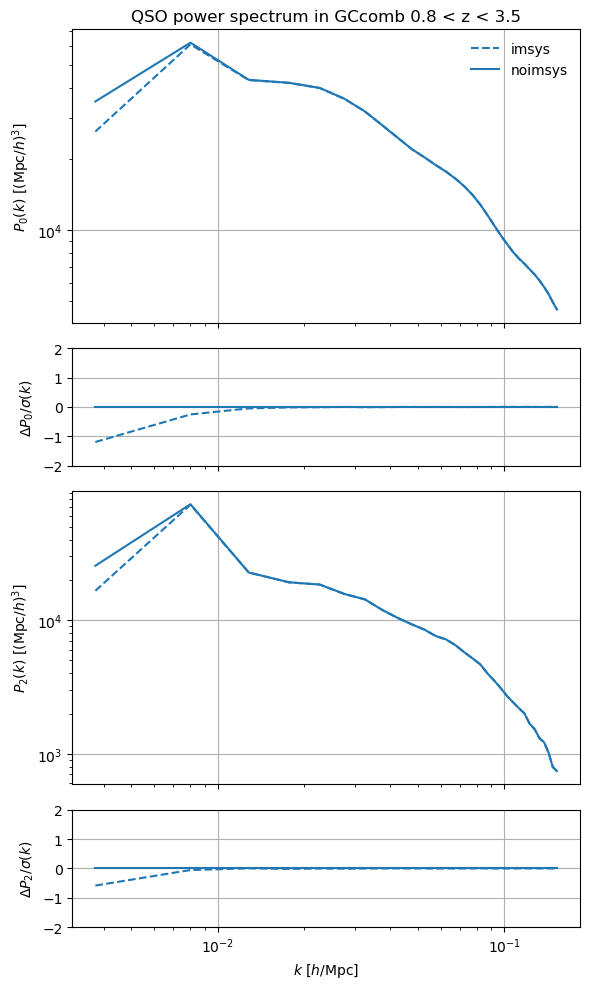

In [64]:
analysis = 'png_local'
stat = kind = 'mesh2_spectrum'
region = 'GCcomb'
tracers = ['LRG', 'ELG_LOPnotqso', 'QSO']
weights = ['default-noimsys-oqe','default-oqe']
rebin = 5

version = 'glam-uchuu-v1-altmtl'
stats_dir = Path('/global/cfs/cdirs/desi/mocks/cai/LSS/DA2/mocks/desipipe/') / analysis

reference = 'noimsys' # the reference to compare too. This is used in the diff panel of the  plots
cases = {'imsys':   {'version': 'glam-uchuu-v1-altmtl', 'weight': 'default-oqe', 'cut': False, 'auw': False},
         'noimsys': {'version': 'glam-uchuu-v1-altmtl', 'weight': 'default-noimsys-oqe', 'cut': False, 'auw': False}}

colors = dict(zip(cases, ['C0', 'C0', 'C1']))
linestyles = dict(zip(cases, ['--', '-', '-']))

for tracer in tracers:
    zranges = tools.propose_fiducial('zranges',tracer,analysis=analysis)
    print(zranges)
    for zrange in zranges: 
        def get_means_covs():
            means, covs = {}, {}
            for case in cases:
                _tracer = tracer
                _version, _weight, _cut, _auw = (cases[case][name] for name in ['version', 'weight', 'cut', 'auw'])
                fns = tools.get_stats_fn(kind=kind, stats_dir=stats_dir, version=_version, tracer=_tracer, zrange=zrange, 
                                         region=region, cut=_cut, auw=_auw, weight=_weight, imock='*')
                stats = list(map(types.read, fns))
                means[case] = types.mean(stats).select(k=slice(0, None, rebin))
                if len(stats) > 1:
                    covs[case] = types.cov(stats).at.observable.match(means[case])
                else:
                    covs[case] = None
            return means, covs
        means, covs = get_means_covs()
        cases_list = list(means)
        ells = means[cases_list[0]].ells

        fig, lax = plt.subplots(len(ells) * 2, figsize=(6, 10), sharex=True, gridspec_kw={'height_ratios': [2.5, 1] * len(ells)})
        lax[0].set_title(f'{tracer} power spectrum in {region} {zrange[0]:.1f} < z < {zrange[1]:.1f}')
        for ill, ell in enumerate(ells):
            ax = lax[2 * ill]
            # ax.set_ylabel(rf'$k P_{ell:d}(k)$ [$(\mathrm{{Mpc}}/h)^2$]')
            ax.set_ylabel(rf'$P_{ell:d}(k)$ [$(\mathrm{{Mpc}}/h)^3$]')
            for icase, case in enumerate(cases_list):
                pole = means[case].get(ell)
                ax.plot(pole.coords('k'), pole.value().real, color=colors[case], linestyle=linestyles[case], label=case)
            if ill == 0: ax.legend(frameon=False, ncol=1)
            ax.grid(True)
            ax.set_xscale('log')
            ax.set_yscale('log')
        
            ax = lax[2 * ill + 1]
            ax.set_ylabel(rf'$\Delta P_{ell:d} / \sigma(k)$')
            ax.grid(True)
            ax.set_ylim(-2., 2.)
            for icase, case in enumerate(cases_list):
                pole = means[case].get(ell)
                std = covs[case].at.observable.get(ell).std().real
                ax.plot(pole.coords('k'), (pole.value() - means[reference].get(ell).value()).real / std, 
                        color=colors[case], linestyle=linestyles[case])
        lax[-1].set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
        basename = f'AIC_uchuu-glam_mocks_{kind}_{tracer}_z{zrange[0]:.1f}-{zrange[1]:.1f}_{region}.{ext}'
        plt.tight_layout()
        fig.savefig(plot_dir / basename, bbox_inches='tight', pad_inches=0.1, dpi=200)
        plt.show()